In [1]:
import random
import math
import numpy as np
import pandas as pd
from math import sqrt as sqrt
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats

from statsmodels.tsa.api import SARIMAX

from proj_1 import *

seed = 14161 #for sigma to sq repara

In [2]:
y_test = pd.read_csv("heave_filter_test.csv", header = None)
y_test = y_test[0]

y = pd.read_csv("heave_postfilter.csv", header = None)
y = y[0]
p = 30
N = len(y)

X_temp = pd.DataFrame()#0,index = range(0,N-p), columns = col)
for i in range(p-1,0-1,-1):
    X = y[(i):(N-p+i)]
    X_temp["lag"+str(p-i)] = list(X) #has memory of its index 

X = X_temp.to_numpy()
y = np.array(y[p:N])
np.random.seed(seed)

sarimax_mod = SARIMAX(np.array(y), order=(p, 0, 0), trend="n")
sarimax_res = sarimax_mod.fit()
print(sarimax_res.summary())

sarimax_params = sarimax_res.arparams
results_as_html = sarimax_res.summary().tables[1].as_html()
res_pd = pd.read_html(results_as_html, header=0, index_col=0)[0]
sarimax_sig = list(res_pd["coef"])[-1]
#sarimax_params = list(res_pd["coef"])[0:p]
#sarimax_sig = np.var(sarimax_res.resid)
non_restricted = np.arctanh(ARToPacf(sarimax_params))
param_i = list(non_restricted) + [sq_to_sigma2(sarimax_sig)]


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2970
Model:              SARIMAX(30, 0, 0)   Log Likelihood               15408.396
Date:                Fri, 26 Jul 2024   AIC                         -30754.792
Time:                        16:16:10   BIC                         -30568.906
Sample:                             0   HQIC                        -30687.895
                               - 2970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          6.6177      0.014    466.049      0.000       6.590       6.645
ar.L2        -19.9481      0.091   -218.399      0.000     -20.127     -19.769
ar.L3         34.2665      0.277    123.791      0.0

C:\Users\danie\AppData\Local\Temp\ipykernel_14840\2429865680.py:24: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  res_pd = pd.read_html(results_as_html, header=0, index_col=0)[0]


In [3]:
results = minimize(neg_log_lik, param_i, args = ((y, X)), method = "L-BFGS-B")
print("psi approx",barndorff_schou_transformation(np.tanh(results.x[0:p])), "sigma2 approx",sigma2_to_sq(results.x[-1]))
print("final negative log likelihood", results.fun)

[  6.6176607  -19.94810215  34.26653395 -32.8825524    9.7835038
  14.14647663 -13.29672443  -5.90470666  12.92521901   0.6714852
 -10.64600231   2.36851047   6.94890899  -1.73257139  -5.7624764
   1.09581638   6.08006779  -2.03549101  -5.54884095   2.7682463
   5.63471969  -5.83889712  -1.69564489   5.02417953  -0.11658895
  -5.75754243   6.55306958  -3.73662275   1.17495724  -0.16688646] 1.771e-06 -15455.316565476587
[  6.6176607  -19.94810217  34.26653399 -32.88255245   9.78350382
  14.14647666 -13.29672446  -5.90470667  12.92521904   0.6714852
 -10.64600233   2.36851048   6.94890901  -1.7325714   -5.76247642
   1.09581638   6.0800678   -2.03549101  -5.54884096   2.7682463
   5.6347197   -5.83889713  -1.69564489   5.02417954  -0.11658895
  -5.75754244   6.55306959  -3.73662275   1.17495724  -0.16688646] 1.771e-06 -15455.316572024334
[  6.6176607  -19.94810214  34.26653393 -32.88255239   9.7835038
  14.14647662 -13.29672443  -5.90470666  12.925219     0.6714852
 -10.6460023    2.3685

In [4]:
phi_approx = barndorff_schou_transformation(np.tanh(results.x[0:p]))
phi_approx = np.array(phi_approx)
#phi_approx = sarimax_res.arparams # to check if identical 
fitted = fitting_values(y,p, phi_approx)
forecast_param = predicting_values(y, p, N, phi_approx, forecast_len = 125)

print("MSE of fitted to true for SARIMAX initials", mse(y[p:N], fitted))
print("MSE of fitted to true for SARIMAX initials", mse(y_test , forecast_param))

MSE of fitted to true for SARIMAX initials 1.764326858977536e-06
MSE of fitted to true for SARIMAX initials 0.8131093658645978


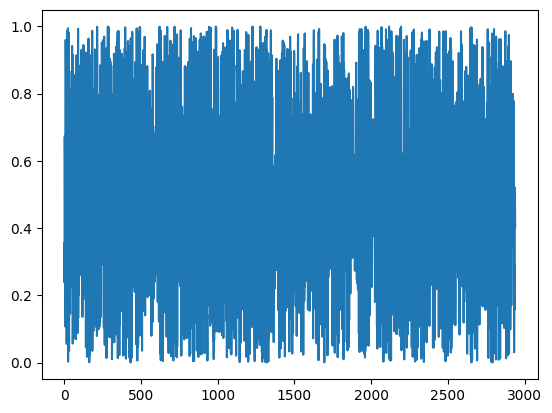

In [5]:
# Transform to uniform marginals
U_2t_sim = stats.norm.cdf(y[p:(len(y)+1)], fitted, np.sqrt(sigma2_to_sq(results.x[-1]) ) )
data_sim = pd.DataFrame(U_2t_sim, columns = ["U_2t_sim"])
data_sim.to_csv("U_2t.csv")

plt.plot(U_2t_sim)
plt.show()

In [6]:
sarimax_ci_down = sarimax_res.get_forecast(125).summary_frame()["mean_ci_lower"]
sarimax_ci_up = sarimax_res.get_forecast(125).summary_frame()["mean_ci_upper"]

matlab_result = pd.read_csv("heave_matlabresult.csv", header = None)
matlab_ci_up = pd.read_csv("heave_matlabresult_up_ci.csv", header = None)
matlab_ci_down = pd.read_csv("heave_matlabresult_down_ci.csv", header = None)

matlab_ci_up = np.array(matlab_ci_up).flatten()
matlab_ci_down = np.array(matlab_ci_down).flatten()

y_graph = list(y[-125:3000])
y_graph = y_graph + list(y_test)

shipheave = pd.read_csv("heave.csv", header = None)
norm=4*sqrt(np.var(shipheave))
norm = 1


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\danie\AppData\Local\Temp\ipykernel_14840\497552053.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  norm=4*sqrt(np.var(shipheave))


[-4.88672137e+00 -1.43909446e+01 -3.31004051e+01 -6.40167259e+01
 -1.08326269e+02 -1.64370808e+02 -2.26747952e+02 -2.85989866e+02
 -3.30208721e+02 -3.47685438e+02 -3.29252122e+02 -2.71582295e+02
 -1.78740872e+02 -6.14242124e+01  6.44782139e+01  1.81123871e+02
  2.72891677e+02  3.29267696e+02  3.46555617e+02  3.28337156e+02
  2.83896345e+02  2.24947471e+02  1.63146055e+02  1.07776877e+02
  6.40207729e+01  3.34744937e+01  1.49329327e+01  5.35768969e+00
  1.35034278e+00  1.66143940e-01] 0.07395558651201412 117384148131.31447
[-4.88672137e+00 -1.43909446e+01 -3.31004051e+01 -6.40167259e+01
 -1.08326269e+02 -1.64370808e+02 -2.26747952e+02 -2.85989865e+02
 -3.30208721e+02 -3.47685437e+02 -3.29252122e+02 -2.71582295e+02
 -1.78740872e+02 -6.14242124e+01  6.44782139e+01  1.81123870e+02
  2.72891676e+02  3.29267696e+02  3.46555617e+02  3.28337156e+02
  2.83896344e+02  2.24947470e+02  1.63146054e+02  1.07776877e+02
  6.40207729e+01  3.34744937e+01  1.49329327e+01  5.35768969e+00
  1.35034278e+00 

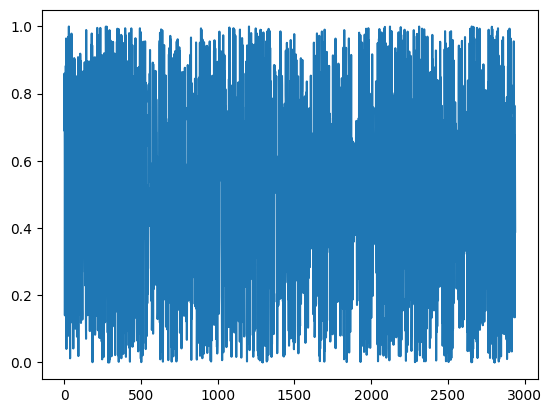

MSE of fitted to true for random initials 1.179579040185846e-05
MSE of predicted to true for random initials 0.9284291953135384


In [7]:
#forecast no initial params

y = pd.read_csv("heave_postfilter.csv", header = None)
y = y[0]
p = 30
N = len(y)

X_temp = pd.DataFrame()#0,index = range(0,N-p), columns = col)
for i in range(p-1,0-1,-1):
    X = y[(i):(N-p+i)]
    X_temp["lag"+str(p-i)] = list(X) #has memory of its index 

X = X_temp.to_numpy()
y = np.array(y[p:N])
np.random.seed(seed)
param_i = [np.random.uniform() for i in range(p+1)]
#param_i = [0.1 for i in range(p+1)]

results = minimize(neg_log_lik, param_i, args = ((y, X)), method = "L-BFGS-B")
print("psi approx",barndorff_schou_transformation(np.tanh(results.x[0:p])), "sigma2 approx",sigma2_to_sq(results.x[-1]))
print("final negative log likelihood", results.fun)

phi_approx = barndorff_schou_transformation(np.tanh(results.x[0:p]))
forecast_noparam = predicting_values(y, p, N, phi_approx, forecast_len = 125)

fitted = fitting_values(y,p, phi_approx)
U_2t_sim = stats.norm.cdf(y[p:(len(y)+1)], fitted, np.sqrt(sigma2_to_sq(results.x[-1]) ) ) #pnorm
data_sim = pd.DataFrame(U_2t_sim, columns = ["U_2t_sim"])
#data_sim.to_csv("U_2t.csv")

plt.plot(U_2t_sim)
plt.show()

print("MSE of fitted to true for random initials",mse(y[p:N], fitted))
print("MSE of predicted to true for random initials",mse(y_test, forecast_noparam))

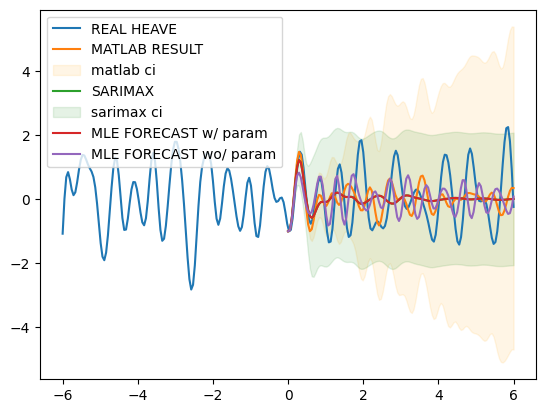

In [8]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-6,6,250),np.array(y_graph)/norm)
ax.plot(np.linspace(0,6,125),matlab_result/norm)
ax.fill_between(np.linspace(0,6,125), matlab_ci_up/norm, matlab_ci_down/norm, color='orange', alpha=.1)

ax.plot(np.linspace(0,6,125),sarimax_res.forecast(125)/norm)
ax.fill_between(np.linspace(0,6,125), sarimax_ci_up/norm, sarimax_ci_down/norm, color='green', alpha=.1)

plt.plot(np.linspace(0,6,125),np.array(forecast_param)/norm)
plt.plot(np.linspace(0,6,125),np.array(forecast_noparam)/norm)

plt.legend([ "REAL HEAVE", "MATLAB RESULT", "matlab ci","SARIMAX", "sarimax ci",  "MLE FORECAST w/ param", "MLE FORECAST wo/ param"])

plt.show()

#taken from moving the sarimax coefficients back to unrestricted , + 0.2 for std
#param_i =  [1.43062821, -1.94276257,  1.35640481, -1.57238812,  1.14566874,
#       -1.36300256,  0.975811  , -1.08354372,  0.63201633, -0.11086265,
#       -0.58308458,  0.21181589,  0.20883829, -0.42056699, -0.23902717,
#        0.27819564,  0.03125508, -0.36669473, -0.13662484,  0.17131567,
#        0.00464366, -0.2815075 , -0.14619721,  0.11172431,  0.05041669,
#       -0.24400596, -0.18424333,  0.06357809,  0.07072182, -0.1744426 , sq_to_sigma2(1.875e-06)] 
#param_i = [0.1 for i in range(p+1)]